In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.decomposition import PCA
import json

In [3]:
import SimpleITK as sitk

# get from https://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd
annotmp = sitk.GetArrayFromImage(sitk.ReadImage(r"E:\ZhixiYun\neuro_morpho_toolbox-0.1-py3.6.egg\neuro_morpho_toolbox\data\annotation_25.nrrd"))

with open(r"./config/tree.json") as f:
    tree = json.load(f)
lutnametoid = dict(zip([t["acronym"] for t in tree], [t["id"] for t in tree]))
lutidtoname = dict(zip([t["id"] for t in tree], [t["acronym"] for t in tree]))
lutidtorgb = dict(zip([t["id"] for t in tree], [t["rgb_triplet"] for t in tree]))
roughlist = ['Isocortex', 'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CBX', 'CBN']
lutnametorough = {}
for t in tree:
    lutnametorough[t['acronym']] = t['acronym']
    for rough in roughlist:
        if lutnametoid.get(rough) in t['structure_id_path']:
            lutnametorough[t['acronym']] = rough
            break

anno = np.zeros((annotmp.shape[1], annotmp.shape[2], annotmp.shape[0]), dtype=annotmp.dtype)
ix,iy,iz=np.where(annotmp>0)
anno[iy,iz,ix]=annotmp[ix,iy,iz]

In [4]:
volume_dict_path = r'./config/CCF_volume_25um.json'
if not os.path.exists(volume_dict_path):
    volume_dict = {}
    for t in tree:
        tid=t['id']
        tidlist = []
        for tt in tree:
            if tid in tt['structure_id_path']:
                tidlist.append(tt['id'])
        volume_dict[int(tid)] = int(np.sum(np.isin(anno,tidlist)))
    with open(volume_dict_path, 'w') as f:
        json.dump(volume_dict, f, indent=4)
else:
    with open(volume_dict_path) as f:
        volume_dict = json.load(f,object_hook=lambda x:{int(k): v for k, v in x.items()})

In [5]:
material_path = r"E:\ZhixiYun\Projects\Neuron_Morphology_Table\Materials"


In [6]:
df_ct1 = pd.concat([pd.read_csv(os.path.join(material_path,"cell_type/s_type","AIBS+SEU-ALLEN_Full_1741.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","MouseLight_Full_1200.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","ION_Axon_6357.csv"), index_col=0)
                  ])
df_ct1.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_ct1.index]


df_ct2 =  pd.read_csv(os.path.join(material_path, "cell_type/s_type", 'SEU_Dendrite_10860.csv'),index_col=0)
df_ct2.index = [x.replace('.semi_r','').replace('.auto_r','').replace('.semi_f','') for x in df_ct2.index]


In [7]:
def ct_ccf_sort(ctlist):
    ctlist = [x.replace("23","2/3") for x in ctlist]
    select_ct_sorted = []
    for item in tree:
        if item["acronym"] in ctlist:
            select_ct_sorted.append(item["acronym"])
    return select_ct_sorted

def get_rgb_triplet(name):
    rgb_triplet = [204, 204, 204]
    for t in tree:
        if t['acronym'] == name:
            rgb_triplet = t['rgb_triplet']
            break
    rgb_triplet[0] /= 255.0
    rgb_triplet[1] /= 255.0
    rgb_triplet[2] /= 255.0

    return rgb_triplet

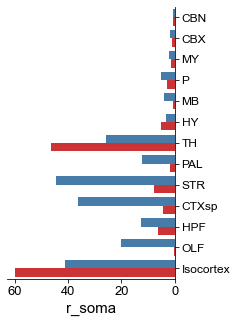

In [12]:
tmpseries = df_ct1.rough.value_counts()
tsidx = ct_ccf_sort(list(tmpseries.index))
tsidx.remove('fiber tracts')
tsidx.remove('root')
tmpdf1 = pd.DataFrame([],columns=['CellType','counts','class'])
tmpdf1.CellType=tsidx
tmpdf1.counts=tmpseries.loc[tsidx].values
tmpdf1['class']="9298 full/axons"
for ind in tmpdf1.index:
    tmpdf1.loc[ind,'r_soma'] = tmpdf1.loc[ind,'counts'] / (volume_dict.get(lutnametoid[tmpdf1.loc[ind,'CellType']]) /40**3)


tmpseries = df_ct2.rough.value_counts()
tsidx = ct_ccf_sort(list(tmpseries.index))

tmpdf2 = pd.DataFrame([],columns=['CellType','counts','class'])
tmpdf2.CellType=tsidx
tmpdf2.counts=tmpseries.loc[tsidx].values
tmpdf2['class'] = '11k dendrites'

for ind in tmpdf2.index:
    tmpdf2.loc[ind,'r_soma'] = tmpdf2.loc[ind,'counts'] / (volume_dict.get(lutnametoid[tmpdf2.loc[ind,'CellType']]) /40**3)

tmpdf = pd.concat([tmpdf1,tmpdf2])

fig,ax=plt.subplots(1,1,figsize=(3,5))
sns.barplot(data=tmpdf,y='CellType',x='r_soma',hue='class',ax=ax,palette=sns.color_palette('Set1'), orient='h')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.title('Soma Density',fontsize=15)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax.yaxis.set_ticks_position('right')
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('r_soma',fontsize=15)
plt.ylabel('')
# plt.legend(loc='upper left',fontsize=12)
ax.get_legend().remove()
plt.savefig(r'./fig1/soma_density.svg',dpi=300,
                                           bbox_inches='tight',facecolor="white")
plt.show()

tmpdf.to_csv(r'./fig1/soma_density.csv')

In [13]:
def hemisphere_concat(df):
    col_num = int(df.shape[1]/2)
    return pd.DataFrame(df.iloc[:,:col_num].values + df.iloc[:,col_num:].values ,index=df.index,columns=[x.replace('ipsi_','') for x in df.columns[:col_num]])
    
    
df_arbor_all = pd.read_csv(os.path.join(material_path, 'projection_matrix/AutoArbor/', 'All_Arbor_Projection.csv'),index_col=0)
df_arbor_den = pd.read_csv(os.path.join(material_path, 'projection_matrix/AutoArbor/', 'Dendritic_Arbor_Projection.csv'),index_col=0)
df_arbor_axon = df_arbor_all - df_arbor_den
df_arbor_axon = hemisphere_concat(df_arbor_axon)
df_arbor_den = hemisphere_concat(df_arbor_den)


In [14]:

def rough_archive(df):
    cols = np.array(df.columns)
    df_rough = pd.DataFrame([],index=df.index, columns=roughlist)
    roughcolsmapping = np.array([lutnametorough.get(x) for x in cols])
    for r in roughlist:
        rindice = np.argwhere(roughcolsmapping==r).flatten()
        df_rough.loc[:,r] = df.loc[:,cols[rindice]].values.sum(axis=1)
    return df_rough

df_arbor_axon_rough = rough_archive(df_arbor_axon)
df_arbor_den_rough = rough_archive(df_arbor_den)

# df_arbor_axon_rough[df_arbor_axon_rough>0]=1
# df_arbor_den_rough[df_arbor_den_rough>0]=1

# df_arbor_axon_rough = df_arbor_axon_rough.astype(int)
# df_arbor_den_rough = df_arbor_den_rough.astype(int)



In [17]:
# df_arbor_axon_rough.sum(),df_arbor_den_rough.sum()
tmpdf = pd.DataFrame(np.array([
    2*roughlist,
    list(df_arbor_axon_rough.sum().values/np.array([volume_dict.get(lutnametoid[x])*25**3 for x in roughlist]))+list(df_arbor_den_rough.sum().values/np.array([volume_dict.get(lutnametoid[x])*25**3 for x in roughlist])),
    ['axonal arbor']*len(roughlist)+['dendritic arbor']*len(roughlist)
]).T, 
index=pd.RangeIndex(2*len(roughlist)), columns=['region','r_arbor','class'])
tmpdf['r_arbor'] = tmpdf['r_arbor'].astype(float)

tmpdf.to_csv(r'./fig1/arbor_density.csv')

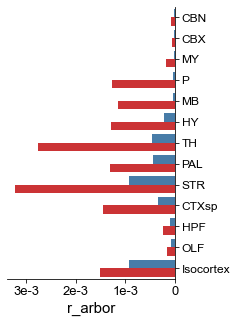

In [18]:
fig,ax=plt.subplots(1,1,figsize=(3,5))
sns.barplot(data=tmpdf,y='region',x='r_arbor',hue='class',ax=ax,palette=sns.color_palette('Set1'), orient='h')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks(rotation=0)
# plt.title('Arbor Density',fontsize=15)
plt.legend(loc='upper left', title='class')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax.yaxis.set_ticks_position('right')
plt.legend(loc='upper left',fontsize=12)
ax.get_legend().remove()
plt.yticks(fontsize=12)
# plt.xticks(fontsize=13,rotation=90)
plt.xticks([0,0.001,0.002,0.003],[0,'1e-3','2e-3','3e-3'],rotation=0,fontsize=13)
plt.xlabel('r_arbor',fontsize=15)
plt.ylabel('')
plt.savefig(r'.\fig1\arbor_density.svg',dpi=300,
                                           bbox_inches='tight',facecolor="white")
plt.show()


In [20]:
df_proj_axon = pd.read_csv(os.path.join(material_path, 'projection_matrix/Axon/','Axon_Projection.csv'), index_col=0).dropna()
df_proj_den = pd.read_csv(os.path.join(material_path, 'projection_matrix/Dendrite/','Dendrite_Projection.csv'), index_col=0).dropna()
del df_proj_den['brain']

df_proj_axon = hemisphere_concat(df_proj_axon)
df_proj_den = hemisphere_concat(df_proj_den)

df_proj_axon[df_proj_axon<100] =0
df_proj_axon[df_proj_axon>0]=1
df_proj_den[df_proj_den<100] =0
df_proj_den[df_proj_den>0]=1

df_proj_axon = df_proj_axon.astype(int)
df_proj_den = df_proj_den.astype(int)

In [21]:
import re
def get_level_regionlist(level=7):
    rlist = []
    for t in tree:
        if len(t['structure_id_path'])==level:
            name=t['acronym']
            if lutnametorough.get(t['acronym'])=='Isocortex':
                name=re.search('[a-zA-Z]+',name).group()
            rlist.append(name)
    return np.unique(rlist)

rlist = get_level_regionlist(9)


In [23]:
dfpa_vc = df_proj_axon.sum(axis=1).value_counts().sort_index()
dfpd_vc = df_proj_den.sum(axis=1).value_counts().sort_index()
dfpd_vc.drop(0,inplace=True)

tmpdf = pd.DataFrame(np.array([list(dfpa_vc.index)+list(dfpd_vc.index),
              list(dfpa_vc.values/np.sum(dfpa_vc.values))+list(dfpd_vc.values/np.sum(dfpd_vc.values)),
              len(dfpa_vc)*['outgoing']+len(dfpd_vc)*['incoming']]).T,
            columns=['#brain region','r_proj','class'])
tmpdf['r_proj'] = tmpdf['r_proj'].astype(float)
tmpdf['#brain region'] = tmpdf['#brain region'].astype(int)

tmpdf.to_csv(r'./fig1/in_out_ratio.csv')

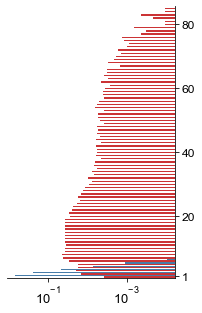

In [24]:
fig,ax=plt.subplots(1,1,figsize=(3*1,5*1))
# sns.barplot(data=tmpdf,y='#brain region',x='value',hue='class',ax=ax,palette=sns.color_palette('Set1'), orient='h')
sns.barplot(data=tmpdf,y='#brain region',x='r_proj',hue='class',ax=ax,palette=sns.color_palette('Set1'), orient='h')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks(rotation=0)
plt.yticks([0]+list(range(19,80,20)))
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
ax.yaxis.set_ticks_position('right')
plt.ylabel('')
plt.xscale('log')

plt.legend(loc='upper left',fontsize=12)
ax.get_legend().remove()
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('r_proj',fontsize=15)
plt.xlabel('')
plt.ylabel('#.Brain regions',fontsize=15)
plt.ylabel('')
# plt.title('arbor density')
# plt.legend(loc='lower right', title='class')
plt.savefig(r'.\fig1\in_out_ratio.svg',dpi=300,
                                           bbox_inches='tight',facecolor="white")
plt.show()

# supplementary

In [26]:
df_ct = pd.concat([pd.read_csv(os.path.join(material_path,"cell_type/s_type","AIBS+SEU-ALLEN_Full_1741.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","MouseLight_Full_1200.csv"), index_col=0), 
                   pd.read_csv(os.path.join(material_path,"cell_type/s_type","ION_Axon_6357.csv"), index_col=0)
                  ])
df_ct['source'] = ['1']*1741+['2']*1200+['3']*6357

usecols=["Center Shift","Relative Center Shift",
         "Average Contraction",  "Average Bifurcation Angle Remote","Average Bifurcation Angle Local",
         "Max Branch Order","Number of Bifurcations","Total Length",
         "Max Euclidean Distance","Max Path Distance","Average Euclidean Distance","25% Euclidean Distance",
         "50% Euclidean Distance","75% Euclidean Distance", "Average Path Distance","25% Path Distance","50% Path Distance","75% Path Distance",       
         '2D Density', '3D Density',
         'Area', 'Volume', 'Width',  'Width_95','Height', 'Height_95', 'Depth', 'Depth_95', 
         'Slimness', 'Slimness_95', 'Flatness', 'Flatness_95']

df_morpho = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Axon_Morphological_Features.csv'),index_col=0)[usecols].dropna(how='any',axis=0)


In [34]:
cortical_list = df_ct[df_ct['rough']=='Isocortex'].index
df_morpho = df_morpho[df_morpho.index.isin(cortical_list)]
df_morpho = pd.concat([df_morpho,df_ct[['source']]],axis=1)
df_morpho = df_morpho.dropna()

df_morpho.to_csv(r'./supp/axon_feature_3_source.csv')

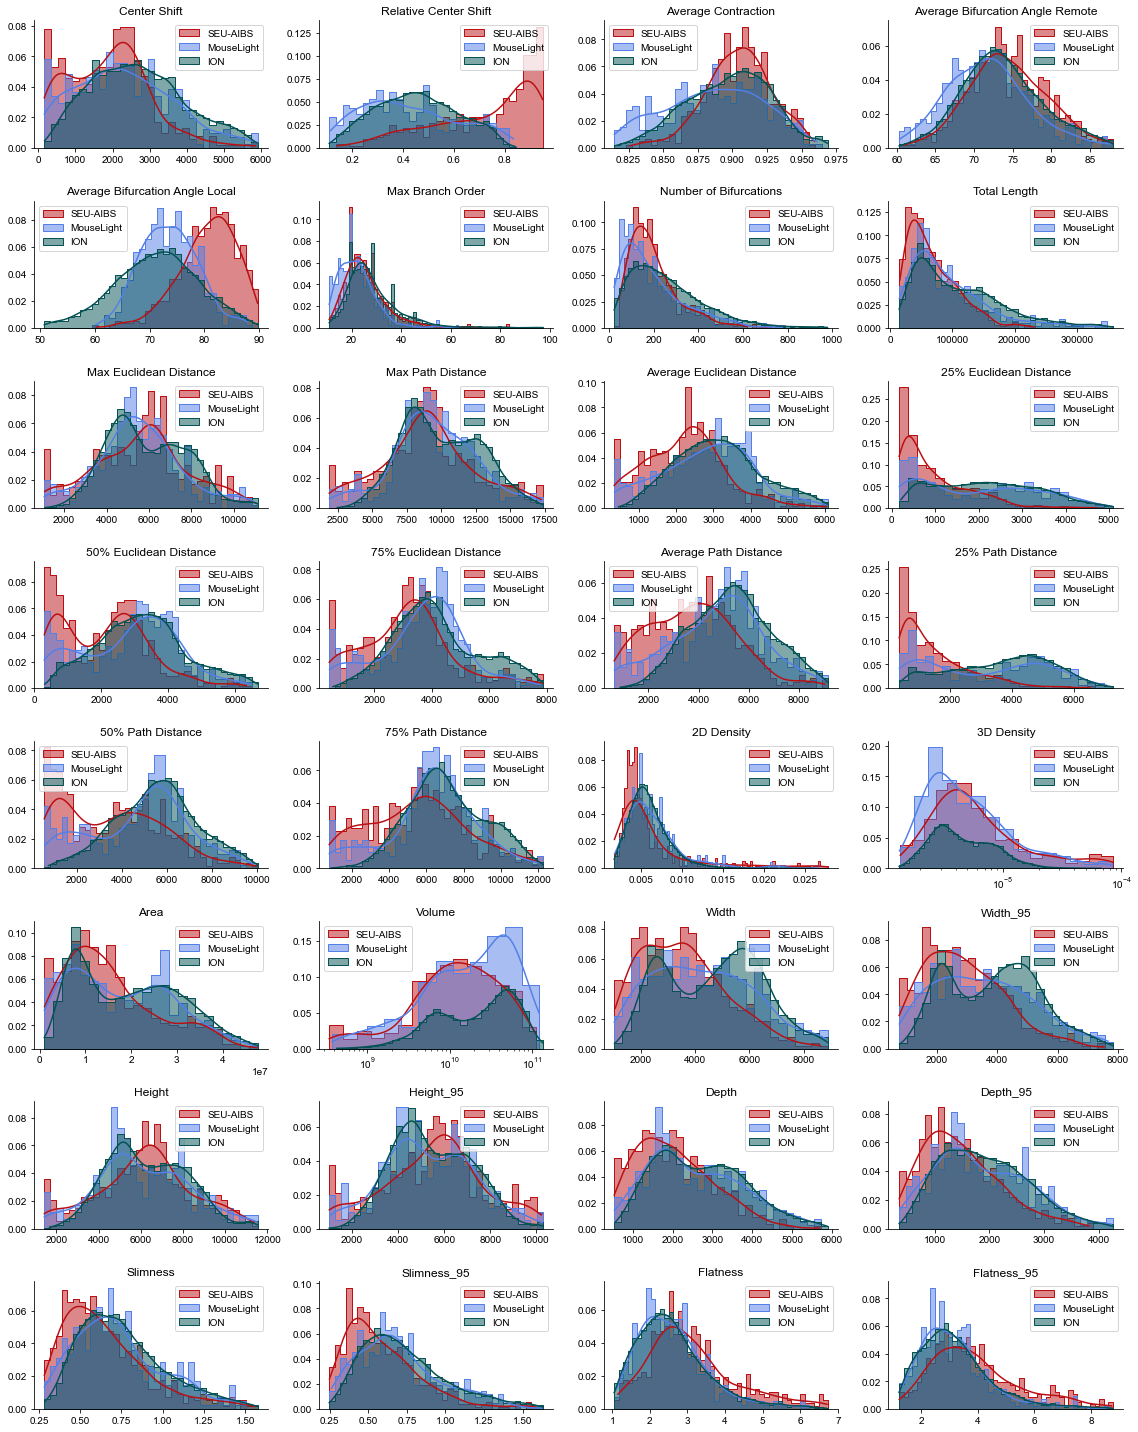

In [32]:
fig, axs = plt.subplots(8,4,figsize=(16,20))
for i in range(len(usecols)):
    fn = usecols[i]
    v1 = df_morpho[df_morpho['source']=='1'][fn].values
    v2 = df_morpho[df_morpho['source']=='2'][fn].values
    v3 = df_morpho[df_morpho['source']=='3'][fn].values
    
    allv = np.array(list(v1)+list(v2)+list(v3))
    l,r=np.percentile(allv,[1,99])
    
    if fn in ['3D Density', 'Volume']: 
        log_scale=True
        bes='auto'
    else:
        log_scale=False
        bes=np.histogram_bin_edges(allv,bins='auto',range=(l,r))

    
    ax = axs[i//4][i%4]
    sns.histplot(ax=ax,data=v1[(v1>=l)&(v1<=r)],log_scale=log_scale,
                 # bins='auto',
                 stat='probability',color='#ba1014',element="step",alpha=0.5,label='SEU-AIBS',bins=bes,kde=True,line_kws={'alpha':1.0})

    sns.histplot(ax=ax,data=v2[(v2>=l)&(v2<=r)],log_scale=log_scale,
                 # bins='auto',
                 stat='probability',color='#537fe7',element="step",alpha=0.5,label='MouseLight',bins=bes,kde=True,line_kws={'alpha':1.0})
    sns.histplot(ax=ax,data=v3[(v3>=l)&(v3<=r)],log_scale=log_scale,
                 # bins='auto',
                 stat='probability',color='#045254',element="step",alpha=0.5,label='ION',bins=bes,kde=True,line_kws={'alpha':1.0})
    ax.set_title(fn.replace('ci',''))
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('')
    
fig.tight_layout()
# plt.savefig('./fig1/supplementary_axon_morpho_feature_corical.png',dpi=300, bbox_inches='tight',facecolor="white")
plt.show()

In [45]:
df_morpho = pd.read_csv(os.path.join(material_path, 'morphology_feature/', 'Dendrite_Morphological_Features.csv'),index_col=0)[usecols].dropna(how='any',axis=0)
df_11k = df_morpho.iloc[df_morpho.index.str.contains('Img')]

df_ct_11k = pd.read_csv(os.path.join(material_path,"cell_type/s_type","SEU_Dendrite_10860.csv"), index_col=0)
df_11k = df_11k[df_11k.index.isin(df_ct_11k[df_ct_11k['rough']=='Isocortex'].index)]

In [46]:
cortical_list = df_ct[df_ct['rough']=='Isocortex'].index
df_morpho = df_morpho[df_morpho.index.isin(cortical_list)]

df_morpho = pd.concat([df_morpho,df_11k],axis=0)
df_morpho = pd.concat([df_morpho,df_ct[['source']]],axis=1)
df_morpho.loc[df_11k.index,'source'] = '4'
df_morpho = df_morpho.dropna()

df_morpho.to_csv(r'./supp/den_feature_3_source.csv')

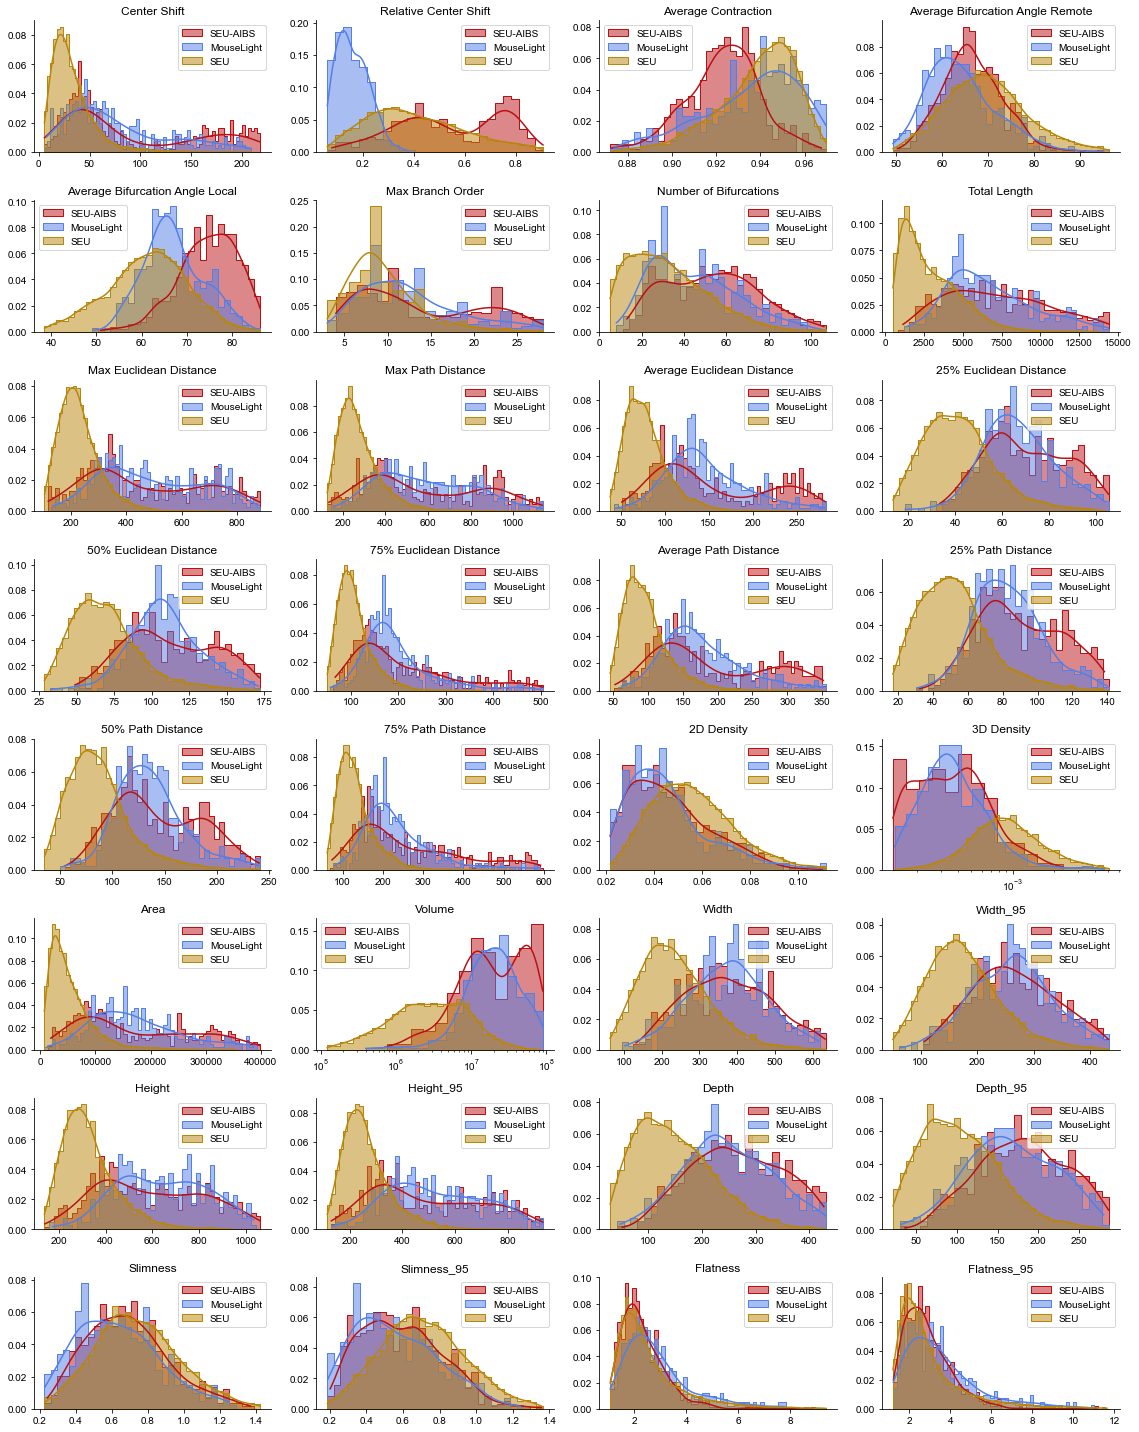

In [44]:
fig, axs = plt.subplots(8,4,figsize=(16,20))
for i in range(len(usecols)):
    fn = usecols[i]
    v1 = df_morpho[df_morpho['source']=='1'][fn].values
    v2 = df_morpho[df_morpho['source']=='2'][fn].values
    v3 = df_morpho[df_morpho['source']=='4'][fn].values
    
    allv = np.array(list(v1)+list(v2)+list(v3))
    l,r=np.percentile(allv,[1,99])
    
    if fn in ['3D Density', 'Volume']: 
        log_scale=True
        bes='auto'
    elif fn=='Max Branch Order':
        log_scale=False
        bes=20
    else:
        log_scale=False
        bes=np.histogram_bin_edges(allv,bins='auto',range=(l,r))

    
    ax = axs[i//4][i%4]
    sns.histplot(ax=ax,data=v1[(v1>=l)&(v1<=r)],log_scale=log_scale,
                 # bins='auto',
                 stat='probability',color='#ba1014',element="step",alpha=0.5,label='SEU-AIBS',bins=bes,kde=True,line_kws={'alpha':1.0})

    sns.histplot(ax=ax,data=v2[(v2>=l)&(v2<=r)],log_scale=log_scale,
                 # bins='auto',
                 stat='probability',color='#537fe7',element="step",alpha=0.5,label='MouseLight',bins=bes,kde=True,line_kws={'alpha':1.0})
    sns.histplot(ax=ax,data=v3[(v3>=l)&(v3<=r)],log_scale=log_scale,
                 # bins='auto',
                 stat='probability',color='darkgoldenrod',element="step",alpha=0.5,label='SEU',bins=bes,kde=True,line_kws={'alpha':1.0})
    ax.set_title(fn.replace('ci',''))
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('')
    
fig.tight_layout()
# plt.savefig('./fig1/supplementary_den_morpho_feature_cortical.png',dpi=300, bbox_inches='tight',facecolor="white")
plt.show()